# STDSR23 - Assignment-01

> Put your full name and surname, as well as Telegram alias and group number

Vladislav Kulikov
TG alias: @slewie
Group number: DS21-02

# Quantile implementation

February 2023

## Assignment description

* Obtain the research paper titled ["A Survey of Approximate Quantile Computation on Large-Scale Data"](https://arxiv.org/pdf/2004.08255.pdf)

* Select and implement one of the methods discussed in the paper, following good coding style and with appropriate comments. Your algorithm can be based on `BasicQuantileAlgorithm` class. In that case, your main implementation is in the `compute_quantile` function.
* Prepare a report that includes
    * A detailed explanation of the selected algorithm
    * A listing of the pros and cons of the chosen algorithm
* Test your implementation. More on that below in section `Test`.
* Submit Jupyter Notebook *.ipynb* to the Moodle

Note: Code style, comments, and overall organization of the report will be
taken into account in the grading process.


## Abstract implementation

Can be used as a basic class for your implementation

In [1]:
from typing import List

class BasicQuantileAlgorithm:
    """
    Abstract class for quantile computing algorithm
    """
    
    def __init__(self) -> None:
        """
        Initializer for algorithm
        """
    
    def compute_quantile(self, q) -> float:
        """
        Implementation of some quantile algorithm
        """
        raise NotImplementedError('compute_quantile is not implemented')
    
    def compute(self, q) -> float:
        assert 0.0 <= q <= 1.0, f"q should be in [0;1]. Got {q}"
        """
        Compute the q-th quantile
        
        Hides implementation of _compute_quantile. 
        
        :param q: Quantile to compute, which must be between 0 and 1 inclusive
        :return: q-th quantile
        """
        return self.compute_quantile(q)
    
    # NOTE: multi_compute is just a basic function
    # for computing multiple quantile with one function call. 
    # This can be modified, so that multiple quantiles
    # calculation become efficient. 
    def multi_compute(self, qs) -> List[float]:
        """
        Compute multiple q-th quantiles
        
        :param qs: list of quantiles to compute, 
            all should be between 0 and 1 inclusive
        :return: list of computed quantiles
        """
        return [self.compute(q) for q in qs]

In [2]:
import numpy as np

class NumpyQuantileAlgorithm(BasicQuantileAlgorithm):
    """
    Example of quantile algorithm

    This algorithm implementation is
    based on the numpy.quantile.
    """
    def __init__(self):
        """
        Initializer of the class.

        It initializes self.data with empty list
        """
        self.data = []

    def add_item(self, item):
        """
        Adds an item to the existing data
        """
        self.data.append(item)

    def add_multiple_items(self, items):
        """
        Adds multiple items to the existing data
        """
        self.data += items

    def compute_quantile(self, q) -> float:
        """
        Compute the q-th quantile

        :param q: Quantile to compute, which must be between 0 and 1 inclusive
        :return: q-th quantile
        """
        return np.quantile(self.data, q)

    # NOTE: Here, for multi_compute we
    # can just call the same function
    # compute_quantile, because it could
    # take a vector of multiple quantiles.
    # This is more efficient, than basic
    # function call, because of the
    # vectorized implementation.
    def multi_compute(self, qs) -> List[float]:
        """
        Compute multiple q-th quantiles

        :param qs: list of quantiles to compute,
            all should be between 0 and 1 inclusive
        :return: list of computed quantiles
        """
        return list(self.compute_quantile(q) for q in qs)

In [3]:
import random

class Stream:
    def __init__(self, dataset: List[int], k: int):
        """
        Class that generates a stream of elements
        :param n: number of elements in the stream
        :param k: number of elements in the batch
        :param dataset: dataset to generate stream from
        :param max_value: maximum value of the element
        :param random_seed: seed for random generator
        """
        self.n = len(dataset)
        self.k = k
        self.dataset = dataset
        self.current_index = 0

    def stream_k_elements(self):
        """
        Generate a stream of k elements
        :return: batch of k elements
        """
        res = self.dataset[self.current_index:min(self.current_index + self.k, self.n)]
        self.current_index += min(self.k, self.n - self.current_index)
        return res

In [4]:
from typing import List


class MRL98Algorithm:
    class Buffer:
        def __init__(self, k: int, weight: int, level: int):
            """
            Class that contains information about buffer
            :param k: buffer size
            :param weight: weight of the buffer
            :param level: level of the buffer
            elements: elements in the buffer
            """
            self.k = k
            self.weight = weight
            self.elements = []
            self.level = level


    def __init__(self, n: int, number_of_buffers: int, k: int):
        """
        :param n: number of elements in the input stream
        :param number_of_buffers
        :param k: size of the buffer
        sum_weights: sum of weights of all buffers
        number_of_inf: number of inf elements which are added to the buffer to make it full
        """
        self.n = n
        self.number_of_inf = 0
        self.sum_weights = 0
        self.number_of_buffers = number_of_buffers
        self.k = k



    def new_operation(self, buffer: Buffer, elements: List, level: int):
        """
        Initialize fields of the empty buffer and fill it with elements from the input stream.
        If the number of elements in the input stream is less than the size of the buffer,
        then add +inf and -inf elements to the buffer.
        :param elements: elements from the input stream
        :param buffer: empty buffer
        :param level: level of the buffer
        """
        buffer.level = level
        buffer.elements = elements
        buffer.weight = 1
        while len(buffer.elements) < self.k - 1:
            buffer.elements.append(float('inf'))
            buffer.elements.append(float('-inf'))
            self.number_of_inf += 2


    def collapse(self, buffers: List[Buffer], level: int):
        """
        Collapse all input buffers into one(first) buffer.

        :param buffers: list of buffers to collapse
        :param level: level of the new buffer
        """
        sum_weights = 0
        for buffer in buffers:
            buffer.elements.sort()
            sum_weights += buffer.weight

        collapsed = []
        offset = (sum_weights + sum_weights % 2) // 2
        current_position = 0
        cursors = [0] * self.number_of_buffers
        while len(collapsed) < self.k:
            min_id = 0
            min_value = float('inf')
            for i in range(len(buffers)):
                if cursors[i] >= self.k:
                    continue
                if buffers[i].elements[cursors[i]] < min_value:
                    min_value = buffers[i].elements[cursors[i]]
                    min_id = i
            if current_position + buffers[min_id].weight >= offset:
                collapsed.append(buffers[min_id].elements[cursors[min_id]])
                offset += sum_weights

            cursors[min_id] += 1
            current_position += buffers[min_id].weight
        buffers[0].elements = collapsed.copy()
        buffers[0].weight = sum_weights
        buffers[0].level = level
        for i in range(1, len(buffers)):
            buffers[i].elements = []
            buffers[i].weight = 0
            buffers[i].level = 0

    def output(self, buffers: List[Buffer]):
        """
        Select an element as the quantile answer from b buffers.
        :param buffers:
        :return:
        """
        self.sum_weights = 0
        self.number_of_inf = (self.number_of_inf + self.n) / self.n
        for buffer in buffers:
            buffer.elements.sort()
            self.sum_weights += buffer.weight

    def find_quantile(self, quantiles: List[float], buffers: List[Buffer]):
        """
        Find quantile in the buffer.
        We parallelize the algorithm by finding quantiles in different buffers.
        To do this, we find the position of the quantile in the buffer and then find the element in the buffer that is located at this position.
        :param quantiles: quantiles to find
        :param buffers: buffers to find quantiles in
        :return: list of computed quantiles
        """
        result = []
        quantile_index = 0
        current_position = 0
        cursors = [0] * self.number_of_buffers
        quantile = (2 * quantiles[quantile_index] + self.number_of_inf - 1) / 2 * self.number_of_inf
        find_pos = self.sum_weights * self.k * quantile
        while quantile_index < len(quantiles):
            min_id = 0
            min_value = float('inf')
            for i in range(self.number_of_buffers):
                if cursors[i] >= len(buffers[i].elements):
                    continue
                if buffers[i].elements[cursors[i]] < min_value:
                    min_value = buffers[i].elements[cursors[i]]
                    min_id = i

            current_position += buffers[min_id].weight
            cursors[min_id] += 1
            while current_position >= find_pos:
                result.append(min_value)
                quantile_index += 1
                if quantile_index >= len(quantiles):
                    break
                quantile = (2 * quantiles[quantile_index] + self.number_of_inf - 1) / 2 * self.number_of_inf
                find_pos = self.sum_weights * self.k * quantile
        return result

    def run(self, stream: Stream):
        """
        Firstly, algorithm initializes buffers with weights=0, level=0 and empty elements.
        Then, algorithm iterates over the input stream and performs the following steps:
        If there number of empty buffers bigger tha 1, invoke NEW on each buffer and assign level 0 to each one
        If there is exactly one empty buffer, invoke NEW and assign it level the smallest level among full buffers
        If there is no empty buffer, invoke COLLAPSE on the set of buffers with the smallest level and assign level=smallest_level + 1
        If there is no elements remained in the streaming sequence, algorithm invokes OUTPUT on non-empty buffers
        :param stream: input stream
        :return: list with non-empty buffers
        """
        smallest_level = 0
        number_of_empty_buffers = self.number_of_buffers
        buffers = [self.Buffer(self.k, 1, 0) for _ in range(self.number_of_buffers)]

        empty_buffer_index = 0
        while stream.current_index < stream.n:
            if number_of_empty_buffers > 1:
                dataset = stream.stream_k_elements()
                self.new_operation(buffers[empty_buffer_index], dataset, 0)
                number_of_empty_buffers -= 1
                empty_buffer_index += 1
                smallest_level = 0
            elif number_of_empty_buffers == 1:
                dataset = stream.stream_k_elements()
                self.new_operation(buffers[empty_buffer_index], dataset, smallest_level)
                number_of_empty_buffers -= 1
            else:
                start_collapse = 0
                for i in range(self.number_of_buffers):
                    if buffers[i].level == smallest_level:
                        start_collapse = i
                        break
                self.collapse(buffers[start_collapse:], smallest_level + 1)
                smallest_level += 1
                number_of_empty_buffers = self.number_of_buffers - start_collapse - 1
                empty_buffer_index = start_collapse + 1
        self.output(buffers)
        return buffers

> YOUR REPORT ABOUT THE MRL98 Algorithm

MRL98 requires prior knowledge of the length N of the data stream.

1. The algorithm will use b buffers each of which can store k elements. Therefore, the memory
footprint will be bk elements. Algorithm also associates with each buffer X, a positive integer w(X), which denotes its weight.
Intuitively, the weight of a buffer is the number of input elements represented by each element in the buffer.
The algorithm uses three main operations: NEW, COLLAPSE, and OUTPUT.
2. The NEW operation is invoked when algorithm has empty buffer and the algorithm needs to fill it with a new set of elements.
3. MRL98 has three implementations of the COLLAPSE: Munro-Paterson, ARS and New Algorithm. I chose New Algorithm. The COLLAPSE operation is invoked when all buffers are full and the algorithm needs to collapse the buffers with the smallest level.
3.1. The algorithm first sorts the elements in each buffer in ascending order.
3.2. Then, the algorithm computes the weight of each buffer as the sum of the weights of the buffers that are collapsed.
3.3. Finally, the algorithm puts elements from the buffers with the smallest level into a new buffer with the computed weight.
4. The OUTPUT operation is invoked when the algorithm has no more elements in the input stream, and it needs to output the quantiles.
5. To get the quantiles, we can use the function find_quantile which finds the quantile in the buffer.

Pros:
1. The algorithm consumes less memory than algorithms before that algorithm
2. Memory requirement becomes independent of the size of the dataset at the cost
of probabilistic confidence in the approximation guarantee.
3. Shows good results in terms of accuracy

Cons:
1. Algorithm needs to know the length of the data stream at first.
2. Requires more memory and time than numoy quantile calculation algorithm

> Add comparison of the time and space consumption (with numpy algorithm). Plot them depending on the sample size or time if your algorithm is for time-series quantile calculation.

Quantiles: [0.1        0.14684211 0.19368421 0.24052632 0.28736842 0.33421053
 0.38105263 0.42789474 0.47473684 0.52157895 0.56842105 0.61526316
 0.66210526 0.70894737 0.75578947 0.80263158 0.84947368 0.89631579
 0.94315789 0.99      ]


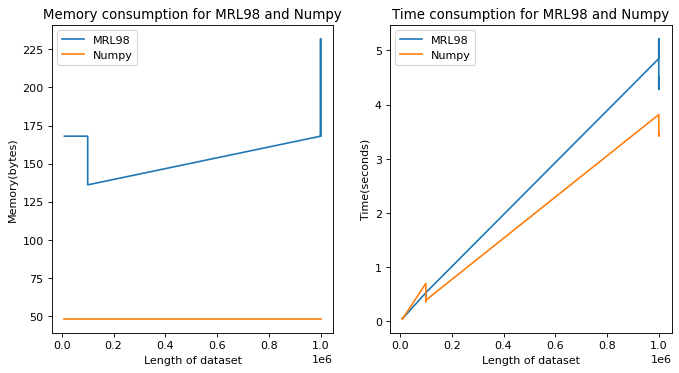

In [5]:
import time
import matplotlib.pyplot as plt
from sys import getsizeof
import numpy

quantiles = np.linspace(0.1, 0.99, 20)
print(f"Quantiles: {quantiles}")

memory_consumption_mrl = []
time_consumption_mrl = []
memory_consumption_numpy = []
time_consumption_numpy = []


n_array = []
test_cases = {
    (10**4, 1): (5, 30),
    (10**4, 2): (6, 24),
    (10**4, 3): (7, 20),
    (10**4, 4): (5, 54),

    (10**5, 1): (5, 55),
    (10**5, 2): (6, 78),
    (10**5, 3): (7, 217),
    (10**5, 4): (3, 953),
    (10**5, 5): (3, 2778),

    (10**6, 1): (7, 54),
    (10**6, 2): (6, 117),
    (10**6, 3): (12, 229),
    (10**6, 4): (8, 583),
    (10**6, 5): (5, 3031),
}

# calculate memory and time consumption for my algorithm and numpy on test cases
for (N, _), (b, k) in test_cases.items():
    dataset = [random.randint(-1000, 1000) for _ in range(N)]

    mrl98 = MRL98Algorithm(N, b, k)
    np_quantile_algorithm = NumpyQuantileAlgorithm()

    stream = Stream(dataset, k)

    start_time_mrl = time.time()
    buffers = mrl98.run(stream)
    quantiles_mrl = mrl98.find_quantile(quantiles, buffers)
    time_consumption_mrl.append(time.time() - start_time_mrl)

    np_quantile_algorithm.add_multiple_items(dataset)
    start_time_numpy = time.time()
    quantiles_numpy = np_quantile_algorithm.multi_compute(quantiles)
    time_consumption_numpy.append(time.time() - start_time_numpy)

    memory_consumption_mrl.append(getsizeof(mrl98) + getsizeof(buffers))
    memory_consumption_numpy.append(getsizeof(np_quantile_algorithm))
    n_array.append(N)


plt.figure(figsize=(10, 5), dpi=80)
ax1 = plt.subplot(121)
ax1.set_title("Memory consumption for MRL98 and Numpy")
ax1.set_xlabel("Length of dataset")
ax1.set_ylabel("Memory(bytes)")
ax1.plot(n_array, memory_consumption_mrl,  label="MRL98")
ax1.plot(n_array, memory_consumption_numpy, label="Numpy")
ax1.legend()


ax2 = plt.subplot(122)
ax2.set_title("Time consumption for MRL98 and Numpy")
ax2.set_xlabel("Length of dataset")
ax2.set_ylabel("Time(seconds)")
ax2.plot(n_array, time_consumption_mrl, label="MRL98")
ax2.plot(n_array, time_consumption_numpy, label="Numpy")
ax2.legend()

plt.show()

## Test

Here you need to show that your algorithm is working properly.
1. Take `normal` distribution. Show, that with increase in sample size, quantiles calculated with your algorithms are become very close to the `inverse cdf` of the distribution. 

2. Perform the same experiment with any other continuous distribution (exponential, logistic, etc.)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import math

np.random.seed(42)
def get_normal_distributed_dataset(N):
    # return normal distributed dataset
    return np.random.normal(0, 1, N)

def get_exponential_distributed_dataset(N):
    # return exponential distributed dataset
    return np.random.exponential(1, N)

def get_logistic_distributed_dataset(N):
    # return logistic distributed dataset
    return np.random.logistic(0, 1, N)

def get_true_quantiles(N, ds, quantiles):
    # sorts dataset and returns true quantiles
    ds.sort()
    true_quantiles = []
    for q in quantiles:
        true_quantiles.append(ds[int(q * N)])
    return true_quantiles

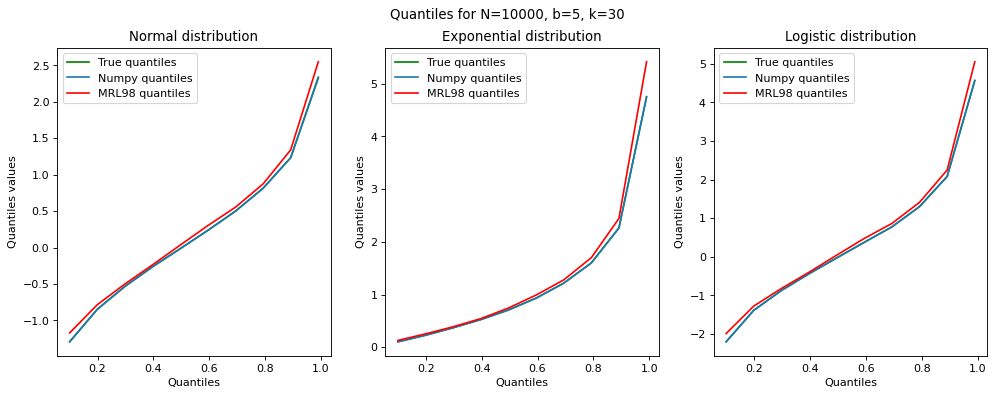

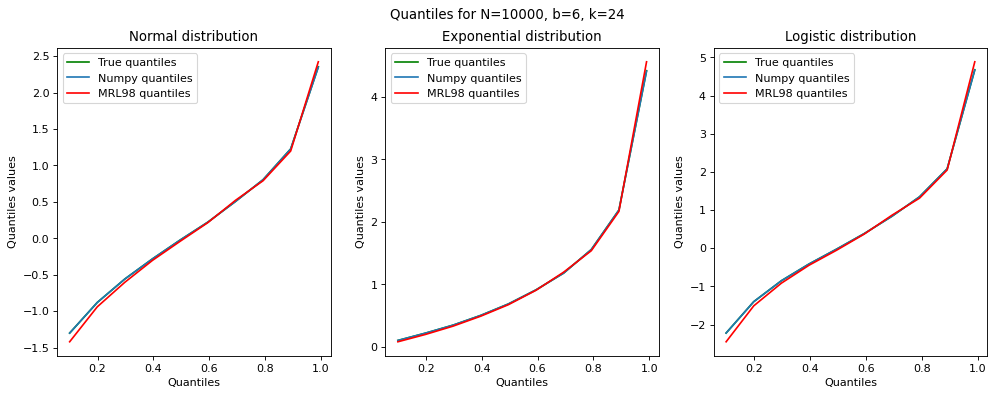

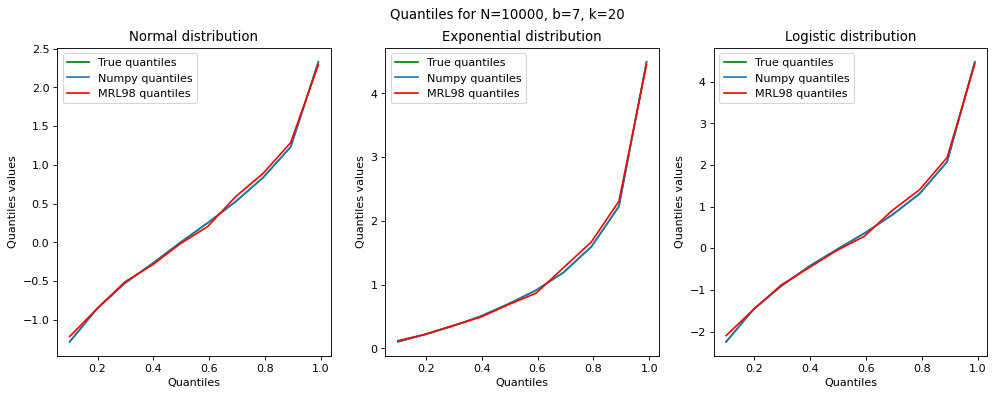

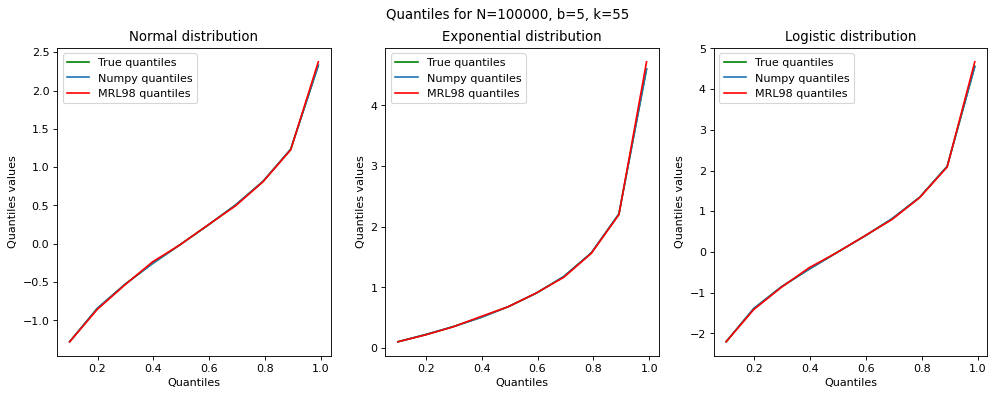

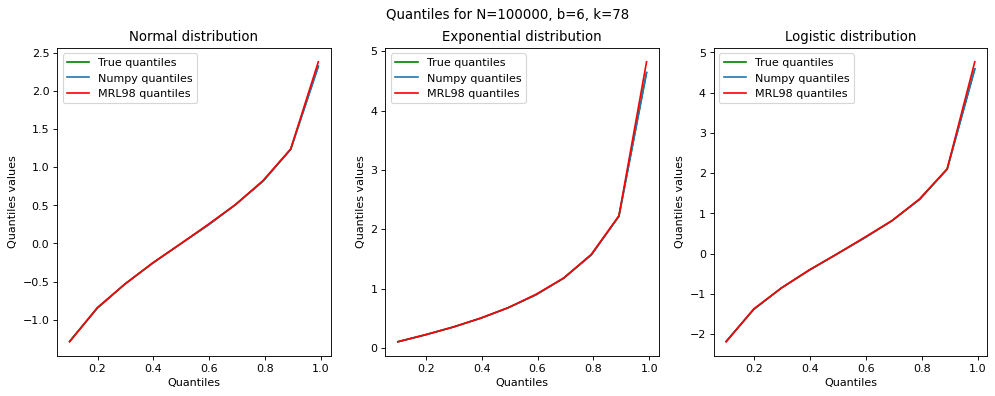

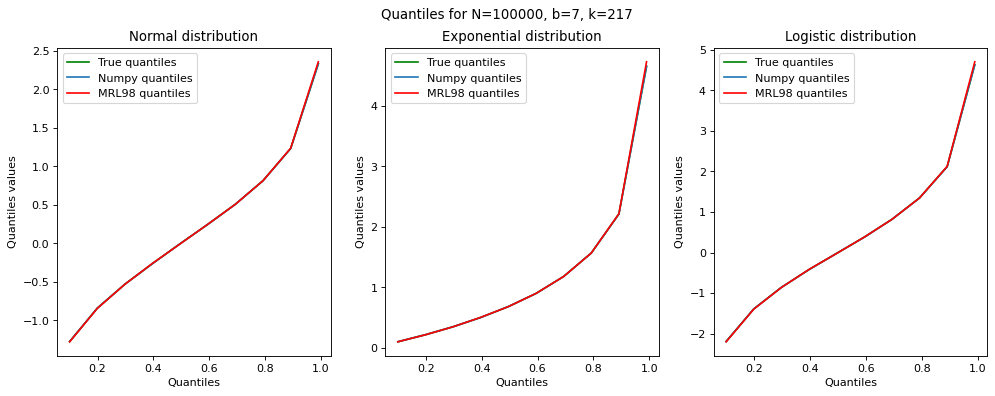

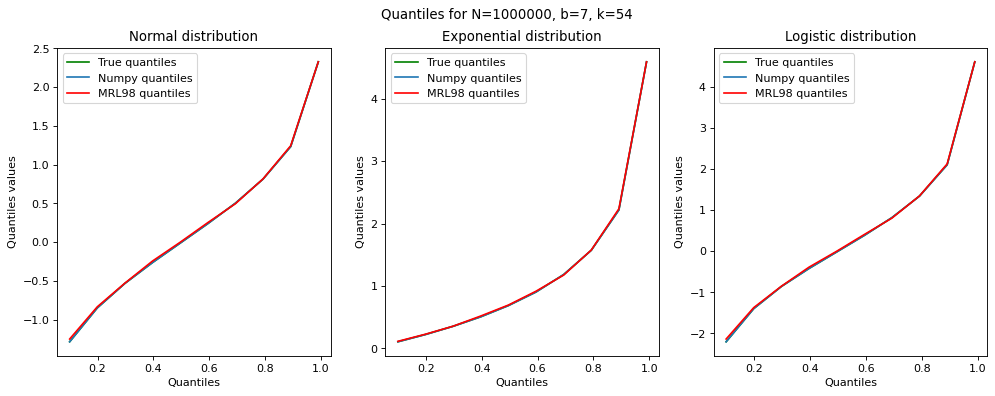

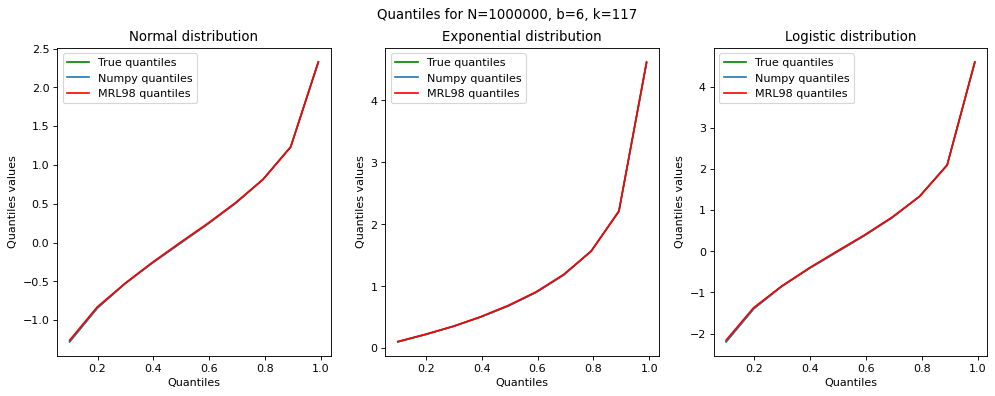

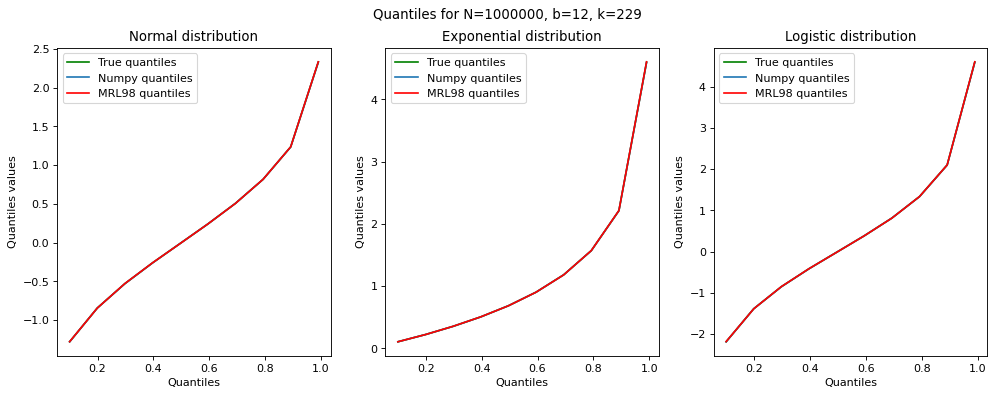

In [7]:
test_cases = {
    (10**4, 1): (5, 30),
    (10**4, 2): (6, 24),
    (10**4, 3): (7, 20),

    (10**5, 1): (5, 55),
    (10**5, 2): (6, 78),
    (10**5, 3): (7, 217),

    (10**6, 1): (7, 54),
    (10**6, 2): (6, 117),
    (10**6, 3): (12, 229),
}

quantiles = np.linspace(0.1, 0.99, 10)
error_mrl_normal = []
error_mrl_exponential = []
error_mrl_logistic = []

error_numpy_normal = []
error_numpy_exponential = []
error_numpy_logistic = []
# calculates difference between true quantiles and mrl98 and numpy on three datasets with different distribution
for (N, _), (b, k) in test_cases.items():
    normal_dataset = list(get_normal_distributed_dataset(N))
    exponential_dataset = list(get_exponential_distributed_dataset(N))
    logistic_dataset = list(get_logistic_distributed_dataset(N))

    true_quantiles_normal = get_true_quantiles(N, normal_dataset, quantiles)
    true_quantiles_exponential = get_true_quantiles(N, exponential_dataset, quantiles)
    true_quantiles_logistic = get_true_quantiles(N, logistic_dataset, quantiles)

    numpy_quantile_algorithm_normal = NumpyQuantileAlgorithm()
    numpy_quantile_algorithm_normal.add_multiple_items(normal_dataset)
    numpy_quantiles_normal = numpy_quantile_algorithm_normal.multi_compute(quantiles)

    numpy_quantile_algorithm_exponential = NumpyQuantileAlgorithm()
    numpy_quantile_algorithm_exponential.add_multiple_items(exponential_dataset)
    numpy_quantiles_exponential = numpy_quantile_algorithm_exponential.multi_compute(quantiles)

    numpy_quantile_algorithm_logistic = NumpyQuantileAlgorithm()
    numpy_quantile_algorithm_logistic.add_multiple_items(logistic_dataset)
    numpy_quantiles_logistic = numpy_quantile_algorithm_logistic.multi_compute(quantiles)

    mrl98_normal = MRL98Algorithm(N, b, k)
    stream_normal = Stream(normal_dataset, k)
    buffers_normal = mrl98_normal.run(stream_normal)

    mrl98_exponential = MRL98Algorithm(N, b, k)
    stream_exponential = Stream(exponential_dataset, k)
    buffers_exponential = mrl98_exponential.run(stream_exponential)

    mrl98_logistic = MRL98Algorithm(N, b, k)
    stream_logistic = Stream(logistic_dataset, k)
    buffers_logistic = mrl98_logistic.run(stream_logistic)

    mrl_quantiles_normal = mrl98_normal.find_quantile(quantiles, buffers_normal)
    mrl_quantiles_exponential = mrl98_exponential.find_quantile(quantiles, buffers_exponential)
    mrl_quantiles_logistic = mrl98_logistic.find_quantile(quantiles, buffers_logistic)


    error_mrl_normal.append(np.linalg.norm(np.array(mrl_quantiles_normal) - np.array(true_quantiles_normal)))
    error_mrl_exponential.append(np.linalg.norm(np.array(mrl_quantiles_exponential) - np.array(true_quantiles_exponential)))
    error_mrl_logistic.append(np.linalg.norm(np.array(mrl_quantiles_logistic) - np.array(true_quantiles_logistic)))

    error_numpy_normal.append(np.linalg.norm(np.array(numpy_quantiles_normal) - np.array(true_quantiles_normal)))
    error_numpy_exponential.append(np.linalg.norm(np.array(numpy_quantiles_exponential) - np.array(true_quantiles_exponential)))
    error_numpy_logistic.append(np.linalg.norm(np.array(numpy_quantiles_logistic) - np.array(true_quantiles_logistic)))

    plt.figure(figsize=(15, 5), dpi=80)
    ax1 = plt.subplot(131)
    ax1.set_title("Normal distribution")
    ax1.set_xlabel("Quantiles")
    ax1.set_ylabel("Quantiles values")
    ax1.plot(quantiles, true_quantiles_normal, label="True quantiles", color="green")
    ax1.plot(quantiles, numpy_quantiles_normal, label="Numpy quantiles")
    ax1.plot(quantiles, mrl_quantiles_normal, label="MRL98 quantiles", color="red")
    ax1.legend()

    ax2 = plt.subplot(132)
    ax2.set_title("Exponential distribution")
    ax2.set_xlabel("Quantiles")
    ax2.set_ylabel("Quantiles values")
    ax2.plot(quantiles, true_quantiles_exponential, label="True quantiles", color="green")
    ax2.plot(quantiles, numpy_quantiles_exponential, label="Numpy quantiles")
    ax2.plot(quantiles, mrl_quantiles_exponential, label="MRL98 quantiles", color="red")
    ax2.legend()

    ax3 = plt.subplot(133)
    ax3.set_title("Logistic distribution")
    ax3.set_xlabel("Quantiles")
    ax3.set_ylabel("Quantiles values")
    ax3.plot(quantiles, true_quantiles_logistic, label="True quantiles", color="green")
    ax3.plot(quantiles, numpy_quantiles_logistic, label="Numpy quantiles")
    ax3.plot(quantiles, mrl_quantiles_logistic, label="MRL98 quantiles", color="red")
    ax3.legend()

    plt.suptitle(f"Quantiles for N={N}, b={b}, k={k}")
    plt.show()


According to the graphs above, we can see that the MRL98 algorithm is working properly for quantile estimation. It shows results are closer to true quantiles.

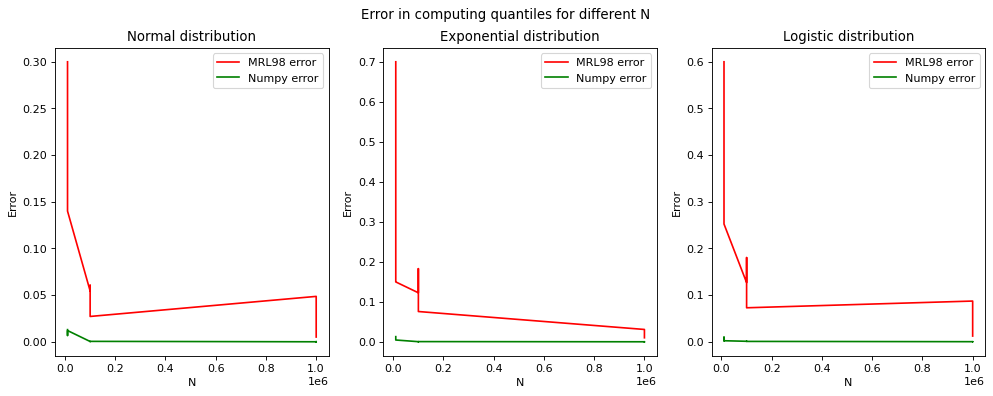

In [8]:
plt.figure(figsize=(15, 5), dpi=80)
ax1 = plt.subplot(131)
ax1.set_title("Normal distribution")
ax1.set_xlabel("N")
ax1.set_ylabel("Error")
ax1.plot([N for (N, _), _ in test_cases.items()], error_mrl_normal, label="MRL98 error", color="red")
ax1.plot([N for (N, _), _ in test_cases.items()], error_numpy_normal, label="Numpy error", color="green")
ax1.legend()

ax2 = plt.subplot(132)
ax2.set_title("Exponential distribution")
ax2.set_xlabel("N")
ax2.set_ylabel("Error")
ax2.plot([N for (N, _), _ in test_cases.items()], error_mrl_exponential, label="MRL98 error", color="red")
ax2.plot([N for (N, _), _ in test_cases.items()], error_numpy_exponential, label="Numpy error", color="green")
ax2.legend()

ax3 = plt.subplot(133)
ax3.set_title("Logistic distribution")
ax3.set_xlabel("N")
ax3.set_ylabel("Error")
ax3.plot([N for (N, _), _ in test_cases.items()], error_mrl_logistic, label="MRL98 error", color="red")
ax3.plot([N for (N, _), _ in test_cases.items()], error_numpy_logistic, label="Numpy error", color="green")
ax3.legend()

plt.suptitle(f"Error in computing quantiles for different N")
plt.show()


According to the graphs above, with increase in sample size, quantiles calculated with MRL98 algorithm is become very close to the `inverse cdf` of the distribution.

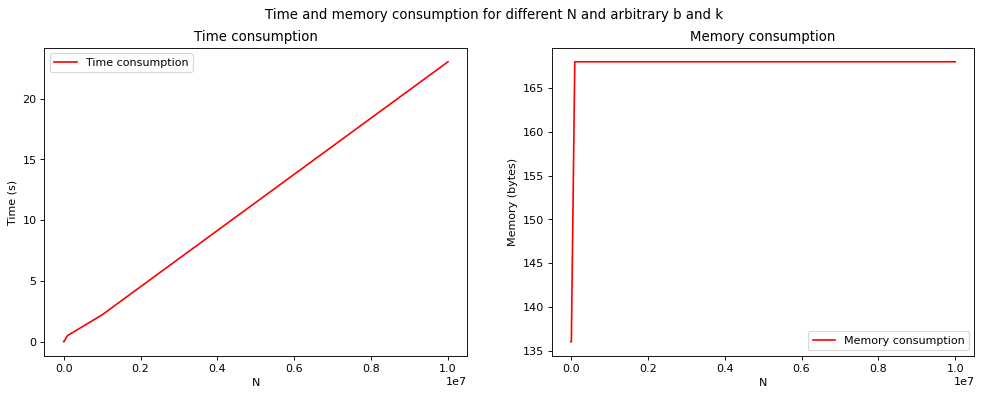

In [278]:
import time
import sys

test_cases = {
    10**2: (3, 10),
    10**3: (3, 17),
    10**4: (4, 34),
    10**5: (5, 57),
    10**6: (7, 178),
    10**7: (8, 894),
}

time_consumption = []
memory_consumption = []
for N, (b, k) in test_cases.items():
    mrl98 = MRL98Algorithm(N, b, k)
    dataset = list(get_normal_distributed_dataset(N))
    stream = Stream(dataset, k)
    start = time.time()
    buffers = mrl98.run(stream)
    mrl_quantiles = mrl98.find_quantile(np.linspace(0.01, 0.99, 10), buffers)
    end = time.time()
    time_consumption.append(end - start)
    memory_consumption.append(sys.getsizeof(mrl98) + sys.getsizeof(buffers))

plt.figure(figsize=(15, 5), dpi=80)
ax1 = plt.subplot(121)
ax1.set_title("Time consumption")
ax1.set_xlabel("N")
ax1.set_ylabel("Time (s)")
ax1.plot([N for N, (b, k) in test_cases.items()], time_consumption, label="Time consumption", color="red")
ax1.legend()

ax2 = plt.subplot(122)
ax2.set_title("Memory consumption")
ax2.set_xlabel("N")
ax2.set_ylabel("Memory (bytes)")
ax2.plot([N for N, (_, _) in test_cases.items()], memory_consumption, label="Memory consumption", color="red")
ax2.legend()

plt.suptitle(f"Time and memory consumption for different N and arbitrary b and k")
plt.show()


Perform an experiment that shows the main purpose of the algorithm. 

For example, some algorithms are created especially for time series data, so you should show that your algorithm is working in time series environment properly.

- [ ] Submit to Moodle!